In [69]:
import os

import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

out_dir = "../../data/05_reporting/problem_set_2"

In [64]:
# helper functions

def load_data(fpath: str | os.PathLike = "../../data/01_raw/penguins.csv"
              ) -> pd.DataFrame:
    return pd.read_csv(fpath)

def plot_priors(model, n_prior_vals=100) -> None:
    plt_dict = {
        r'$\alpha$ prior': model.alpha_prior,
        r'$\beta$ prior': model.beta_prior,
        r'$\sigma$ prior': model.sigma_prior
    }

    fig, axs = plt.subplots(ncols=len(plt_dict), figsize=(15, 5))
    
    for (k, v), ax in zip(plt_dict.items(), axs):
        dist = v.rvs(n_prior_vals)
        labs = v.kwds
        ax.hist(dist, label=labs)
        ax.set_title(k)
        ax.legend()    

# Question 3

## 3.1

In [4]:
df = load_data()
df

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181,3750,MALE
1,Adelie,Torgersen,39.5,17.4,186,3800,FEMALE
2,Adelie,Torgersen,40.3,18.0,195,3250,FEMALE
3,Adelie,Torgersen,36.7,19.3,193,3450,FEMALE
4,Adelie,Torgersen,39.3,20.6,190,3650,MALE
...,...,...,...,...,...,...,...
337,Gentoo,Biscoe,47.2,13.7,214,4925,FEMALE
338,Gentoo,Biscoe,46.8,14.3,215,4850,FEMALE
339,Gentoo,Biscoe,50.4,15.7,222,5750,MALE
340,Gentoo,Biscoe,45.2,14.8,212,5200,FEMALE


In [5]:
our_penguin = "Gentoo"
gentoo = df[df['species'] == our_penguin]

## 3.2

In [91]:
class PenguinModel():

    def __init__(self):
        self.alpha_prior = self.assign_alpha_prior()
        self.beta_prior = self.assign_beta_prior()
        self.sigma_prior = self.assign_sigma_prior()
        self.likelihood = None

    # define model attributes
    def assign_alpha_prior(self, loc: float=3.0, scale: float=2.0):
        return sp.stats.norm(loc=loc, scale=scale)

    def assign_beta_prior(self, loc: float=0.1, scale: float=0.2):
        return sp.stats.norm(loc=loc, scale=scale)

    def assign_sigma_prior(self, s: float=1, scale: float=0):
        return sp.stats.lognorm(s=s, scale=np.exp(scale))

    def assign_likelihood(self, loc, scale):
        mod = sp.stats.norm(loc=loc, scale=scale)
        self.likelihood = mod

    # define methods
    def bootstrap(self, X, stat=np.mean, 
            random_state=np.random.default_rng()
    ) -> np.array:
        res = sp.stats.bootstrap(X, stat, random_state=random_state)
        return res.bootstrap_distribution
    
    def simulate_prior_predictive(self, X):
        X_hat = self.bootstrap((X, ))

        n_prior_samples = len(X_hat)

        alpha = self.alpha_prior.rvs(size=n_prior_samples)
        beta = self.beta_prior.rvs(size=n_prior_samples)
        sigma = self.sigma_prior.rvs(size=n_prior_samples)
        mu = alpha + beta * X_hat

        self.assign_likelihood(loc=mu, scale=sigma)
        y_tilde = self.likelihood.rvs(size=n_prior_samples)

        return X, y_tilde, alpha, beta

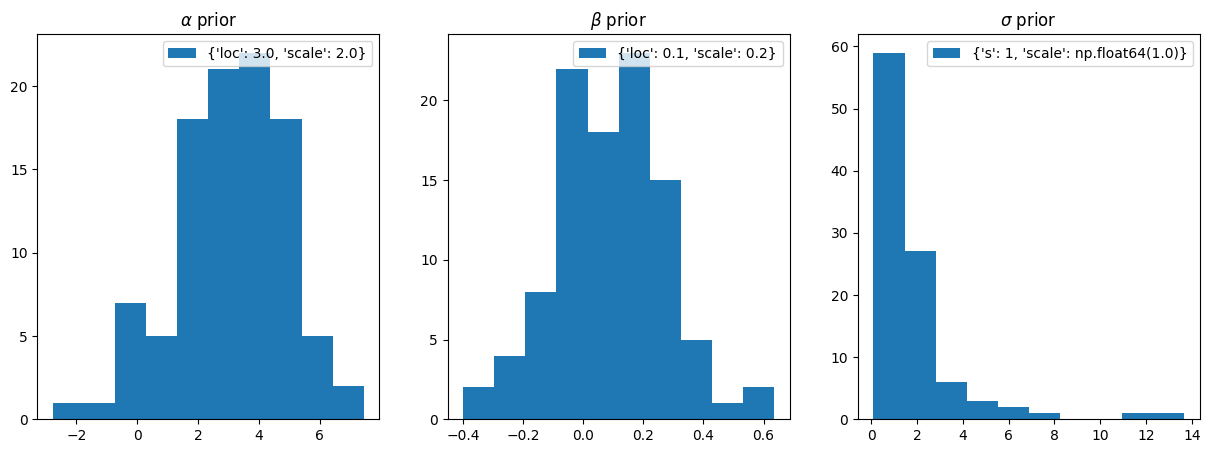

In [92]:
n_prior_vals = 100
model = PenguinModel()
plot_priors(model, n_prior_vals)
plt.savefig(os.path.join(out_dir, 'prior_distributions.pdf'), bbox_inches='tight')

(array([   9.,   97.,  486., 1627., 2808., 2851., 1567.,  475.,   69.,
          10.]),
 array([-135.60406538, -103.85399831,  -72.10393125,  -40.35386419,
          -8.60379712,   23.14626994,   54.896337  ,   86.64640407,
         118.39647113,  150.14653819,  181.89660526]),
 <BarContainer object of 10 artists>)

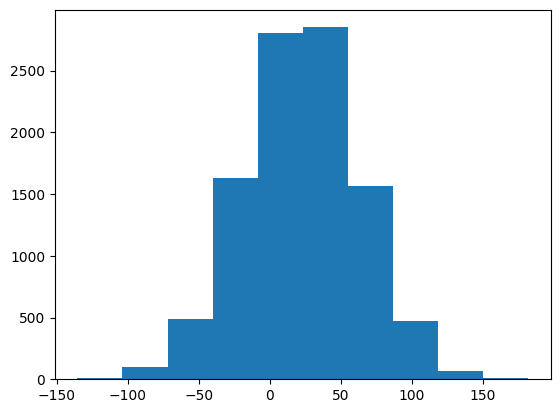

In [93]:
X, y_tilde, alpha, beta = model.simulate_prior_predictive(df['flipper_length_mm'])
plt.hist(y_tilde)

In [99]:
alpha

array([ 3.92063295,  4.14336438, -0.93644213, ...,  1.15041721,
        4.12024424,  0.81051519])

In [101]:
beta

array([ 0.35217011, -0.07062641,  0.19453471, ...,  0.50228436,
        0.26972684,  0.04058612])

KeyboardInterrupt: 

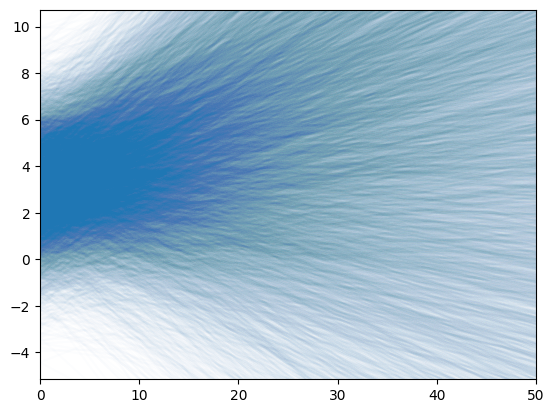

In [104]:
for i in range(len(alpha)):
    xy1 = (0, alpha[i])
    slope = beta[i]

    plt.xlim(0, 50)
    plt.axline(xy1=xy1, slope=slope, alpha=.01)